This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [2]:
import optax
import equinox as eqx

from functools import partial

from math import floor

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import Canoak

# from jax_canoak.shared_utilities.optim import perform_optimization
from jax_canoak.shared_utilities.optim import perform_optimization_batch
from jax_canoak.subjects import convert_met_to_batched_met
from jax_canoak.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)
from jax_canoak.subjects import get_met_forcings, initialize_parameters, Obs
from jax_canoak.models import run_canoak_in_batch

# from jax_canoak.models import run_canoak_in_batch_any

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    visualize_tree_diff,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2

# Model parameters and settings

In [3]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
# niter = 1

batch_size = 2
# batch_size = 1274
f_forcing = "../data/fluxtower/US-Bi1/US-Bi1-forcings.csv"

# Load and set the model forcings

In [4]:
met, n_time = get_met_forcings(f_forcing)
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)

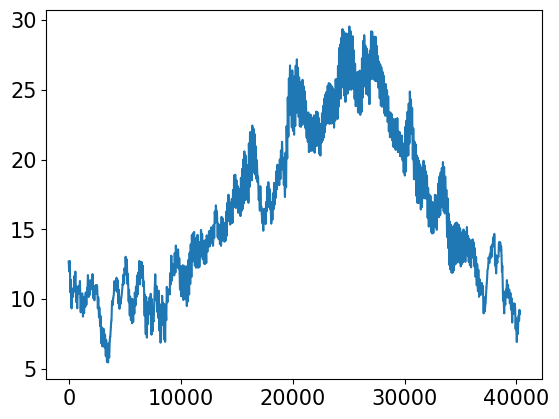

In [5]:
# plt.plot(met.eair_Pa)
# plt.plot(met.es)
# plt.plot(met.lai)
# plt.plot(veg_new.gs)
plt.plot(met.Tsoil)

# Load the observations

In [6]:
# Read the observations
f_obs = "../data/fluxtower/US-Bi1/US-Bi1-fluxes.csv"
obs = pd.read_csv(f_obs)
obs.interpolate(method="linear", limit_direction="both", inplace=True)
# obs[obs == -9999] = np.nan
# obs = jnp.array(obs)

P_obs = jnp.array(obs["P_F"])
LE_obs, H_obs = jnp.array(obs["LE_F_MDS"]), jnp.array(obs["H_F_MDS"])
# LE_obs, H_obs = jnp.array(obs["LE_MODIS"]), jnp.array(obs["H"])
Gsoil_obs, Rnet_obs = jnp.array(obs["G_F_MDS"]), jnp.array(obs["NETRAD"])
Rsoil_obs = jnp.array(obs["Rsoil"])

nan = jnp.nan * jnp.ones(LE_obs.size)
GPP_obs, albedo_obs, Fco2_obs = nan, nan, nan

obs = Obs(
    P_obs, LE_obs, H_obs, GPP_obs, Rnet_obs, albedo_obs, Fco2_obs, Gsoil_obs, Rsoil_obs
)

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_83517/1684496818.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Create the model parameter instance

In [7]:
setup, para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
    met=met,
    obs=obs,
)

# Generate or read the dispersion matrix

In [8]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_US-Hn1.csv")
# np.savetxt("../data/dij/Dij_US-Hn1.csv", np.array(dij), delimiter=',')

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

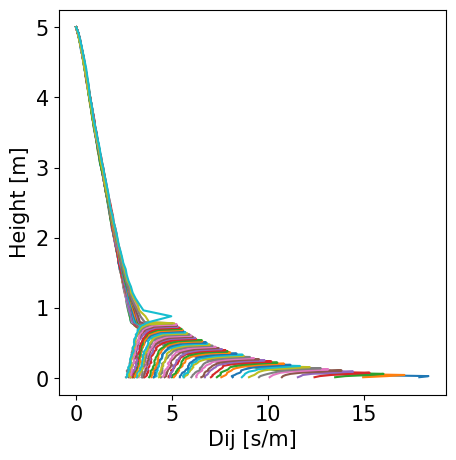

In [9]:
plot_dij(dij, para)

# Run CANOAK!

In [10]:
jax.clear_caches()
canoak_eqx = Canoak(para, setup, dij)
(
    _,
    prof,
    can,
    veg,
    shade,
    sun,
    qin,
    rnet,
    sun_ang,
    ir,
    nir,
    quantum,
    lai,
    leaf_ang,
    soil,
) = run_canoak_in_batch(batched_met, canoak_eqx)

In [11]:
# plt.plot(soil.resp, '.')
# plt.plot(veg.Rd, '.')
# veg.Ps[:100], timesteps[:100]

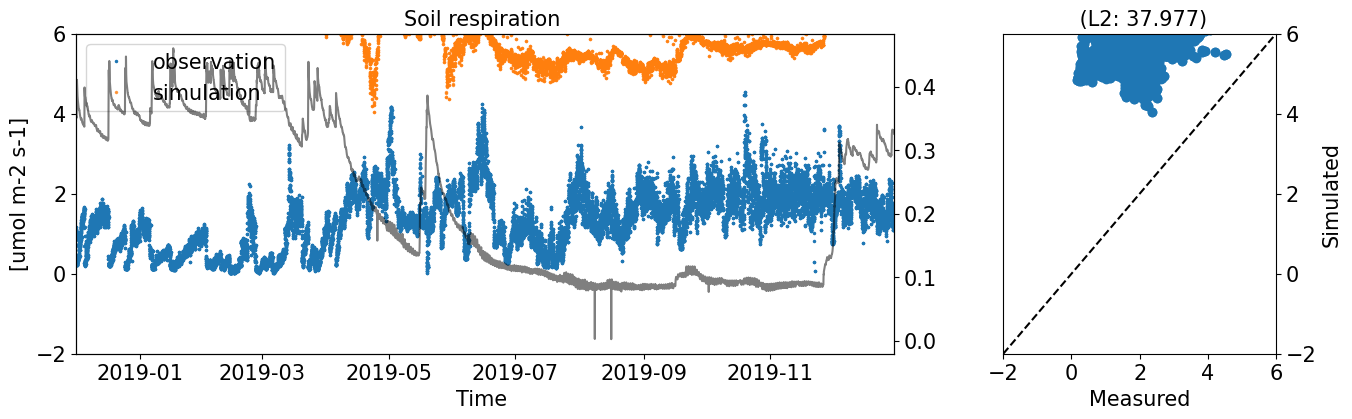

In [12]:
# plt.plot(soil.resp)
timesteps = get_time(met)

fig, ax1, ax2 = plot_timeseries_obs_1to1(
    obs.Rsoil,
    soil.resp,
    # veg.Ps,
    lim=[-2, 6],
    met=met,
    varn="Soil respiration ",
    linestyle=".",
)
ax1.set(ylabel="[umol m-2 s-1]")
ax12 = ax1.twinx()
# ax12.invert_yaxis()
# ax12.plot(timesteps, veg.Ps, "k", alpha=0.5)
# ax12.plot(timesteps, met.CO2, "k", alpha=0.5)
# ax12.plot(timesteps, met.Tsoil, "k", alpha=0.5)
ax12.plot(timesteps, met.soilmoisture, "k", alpha=0.5)
# ax12.plot(timesteps, soil.sfc_temperature, "k")
# ax12.plot(timesteps, obs.P, "k")
# ax12.plot(timesteps, obs.P, "k")
# ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

In [13]:
# Analyze nan
nanind = jnp.where(jnp.isnan(prof.Tair_K.mean(axis=1)))

met.lai[nanind]
# qin.sun_abs[nanind]
# ir.ir_in[nanind]
sun.Tsfc[nanind, :]

Array([], dtype=float64)

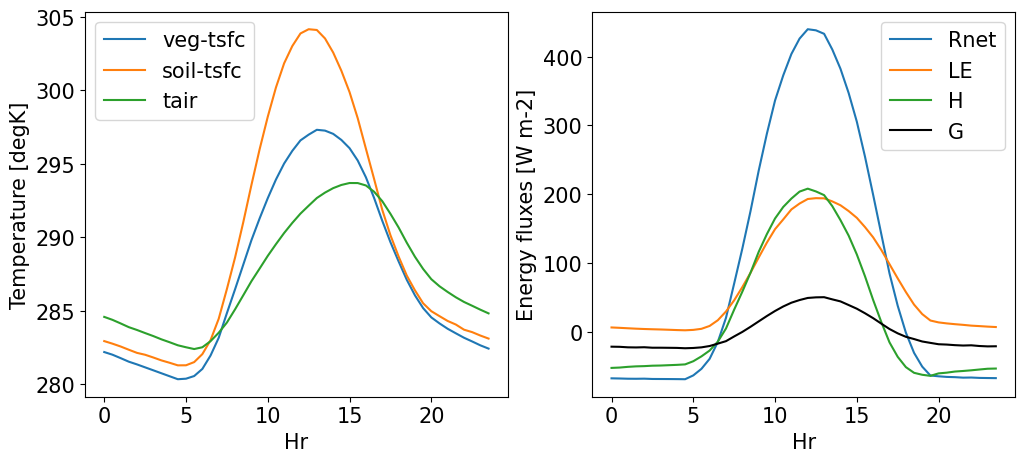

In [14]:
# Daily average
plot_daily(met, soil, veg, para);

<Axes: title={'center': 'IR flux density, W m-2'}, xlabel='Radiation Flux Density', ylabel='Canopy Cumulative LAI'>

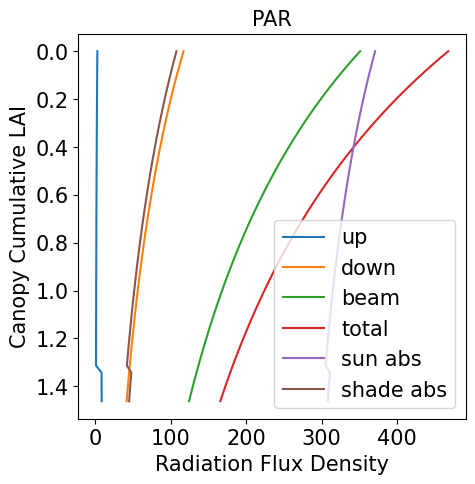

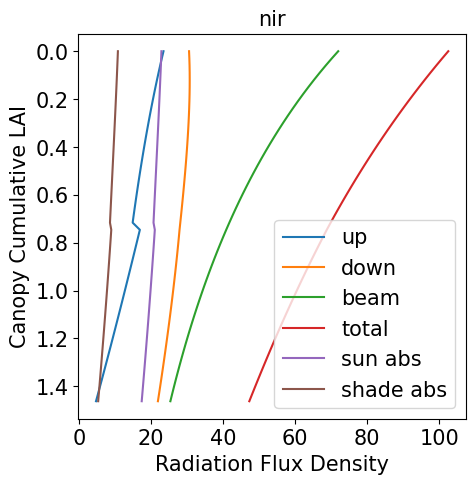

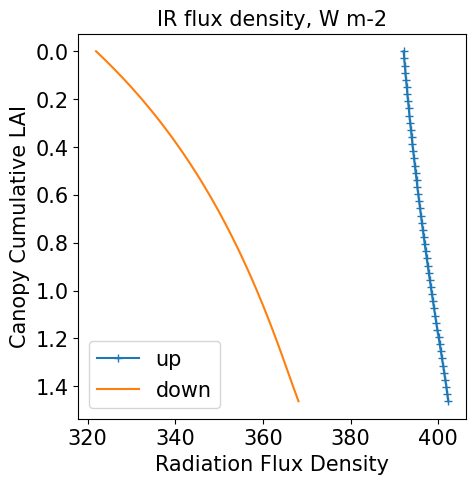

In [15]:
plot_rad(quantum, setup, lai, "PAR")
plot_rad(nir, setup, lai, "nir")
plot_ir(ir, setup, lai)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


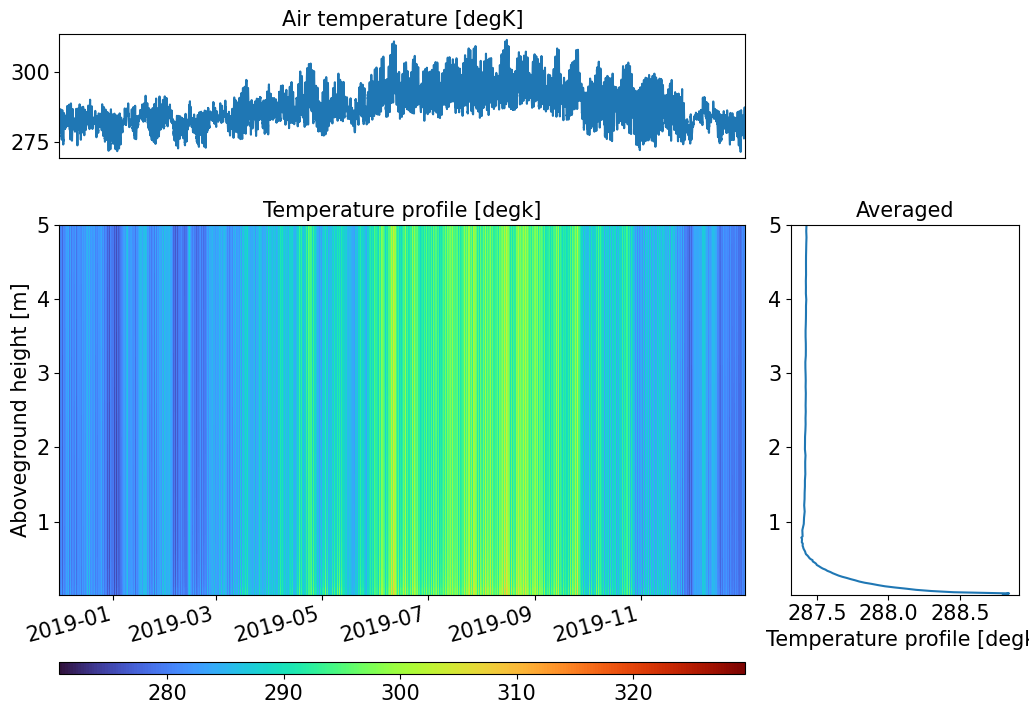

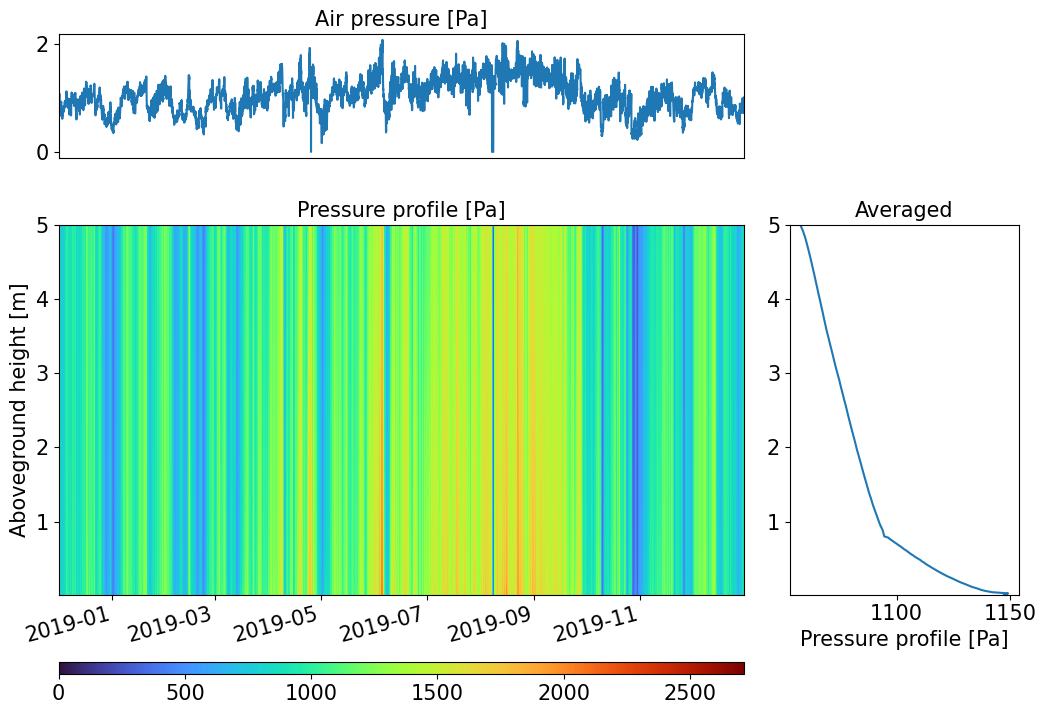

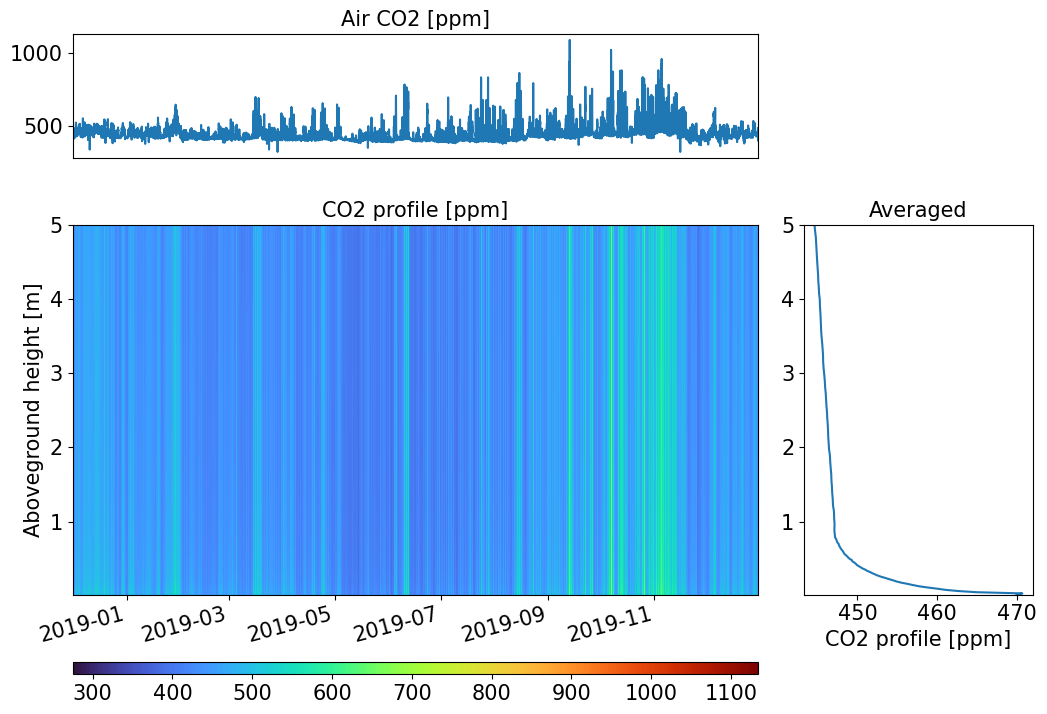

In [16]:
# Profiles
plot_imshow2(
    prof.Tair_K.T,
    met,
    para.zht,
    key="T",
    title="Temperature profile [degk]",
    cmap="turbo",
)
plot_imshow2(
    prof.eair_Pa.T, met, para.zht, key="e", title="Pressure profile [Pa]", cmap="turbo"
)
plot_imshow2(
    prof.co2.T, met, para.zht, key="co2", title="CO2 profile [ppm]", cmap="turbo"
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


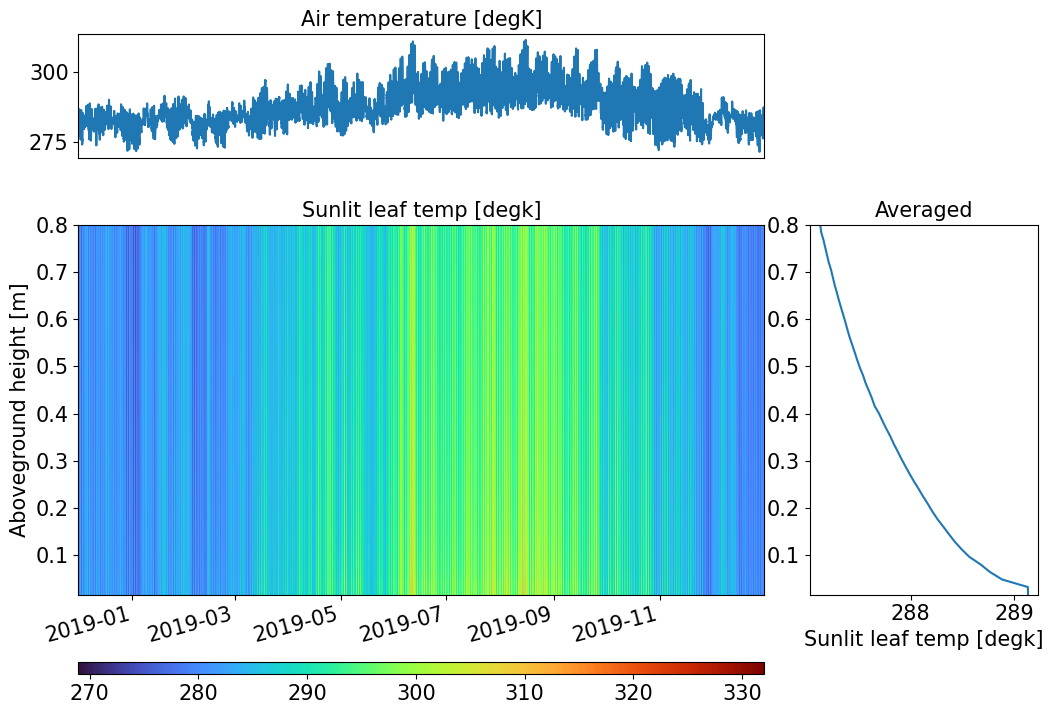

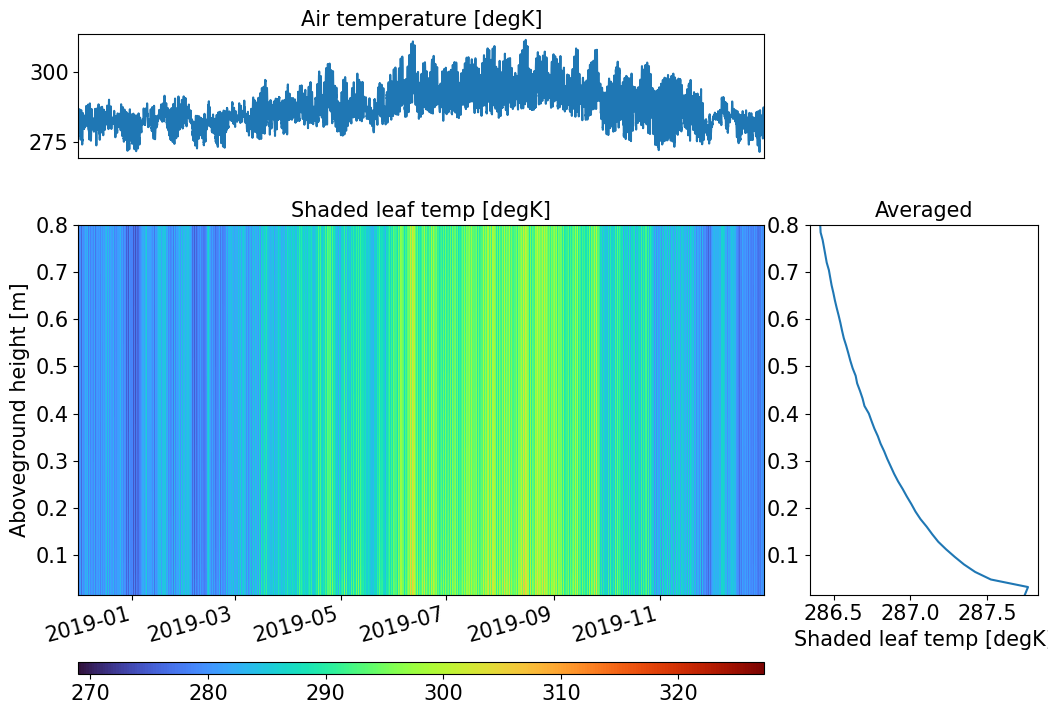

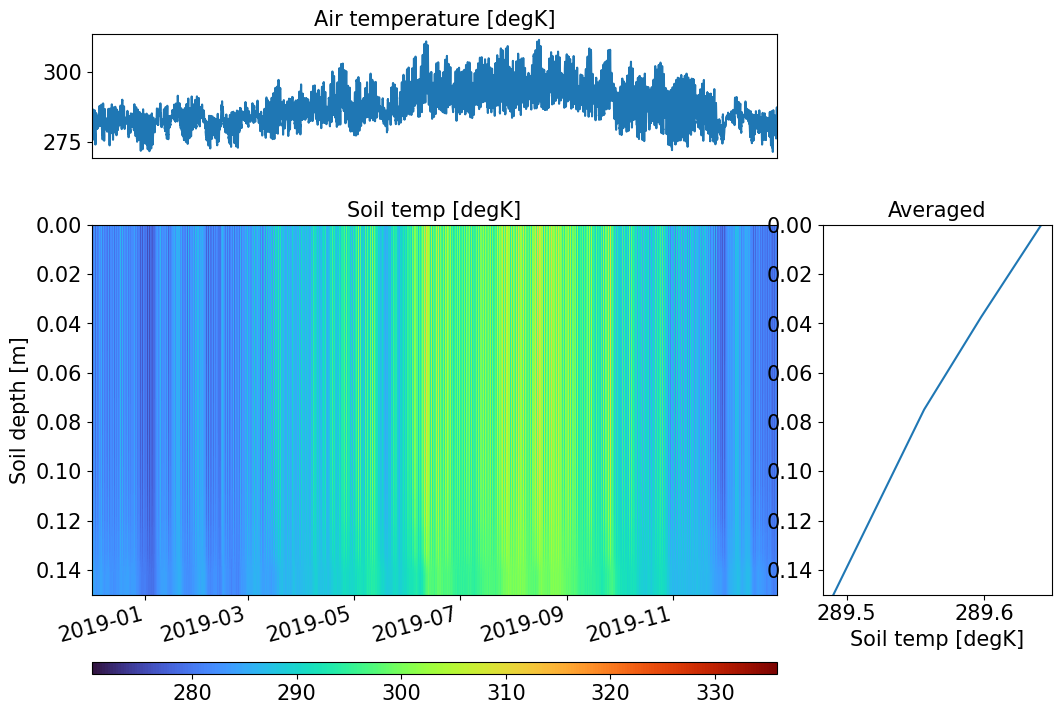

In [17]:
# Temperature
plot_imshow2(
    sun.Tsfc.T, met, para.zht1, key="T", title="Sunlit leaf temp [degk]", cmap="turbo"
)
plot_imshow2(
    shade.Tsfc.T, met, para.zht1, key="T", title="Shaded leaf temp [degK]", cmap="turbo"
)
plot_imshow2(
    soil.T_soil[:, :-1].T,
    met,
    soil.z_soil,
    key="T",
    title="Soil temp [degK]",
    cmap="turbo",
    is_canopy=False,
)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-w

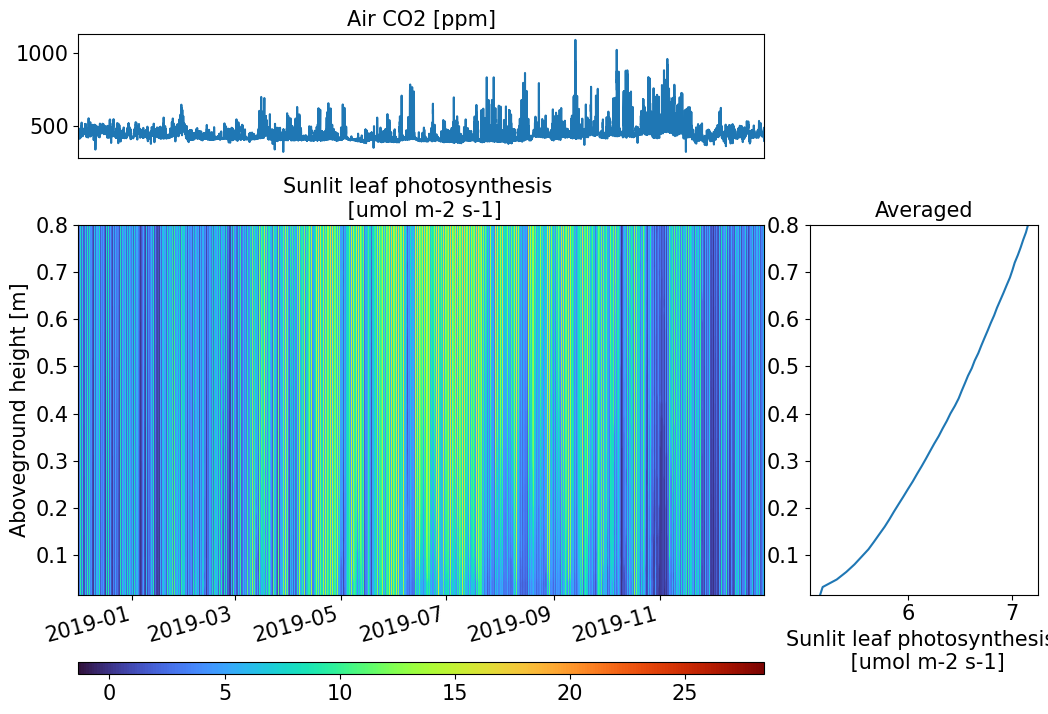

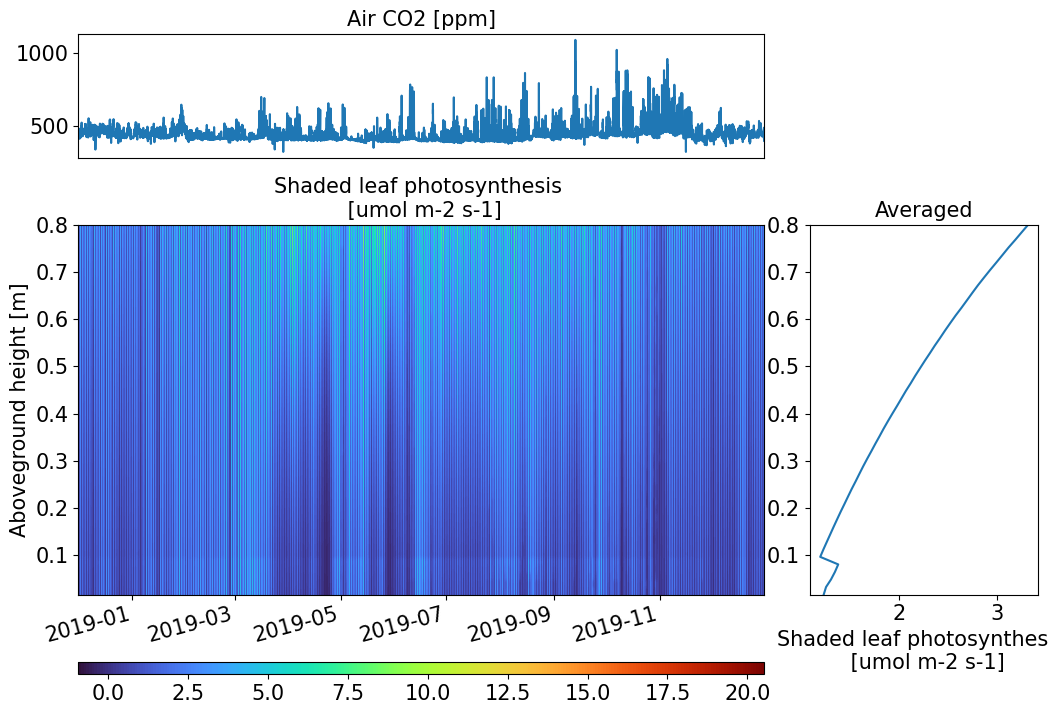

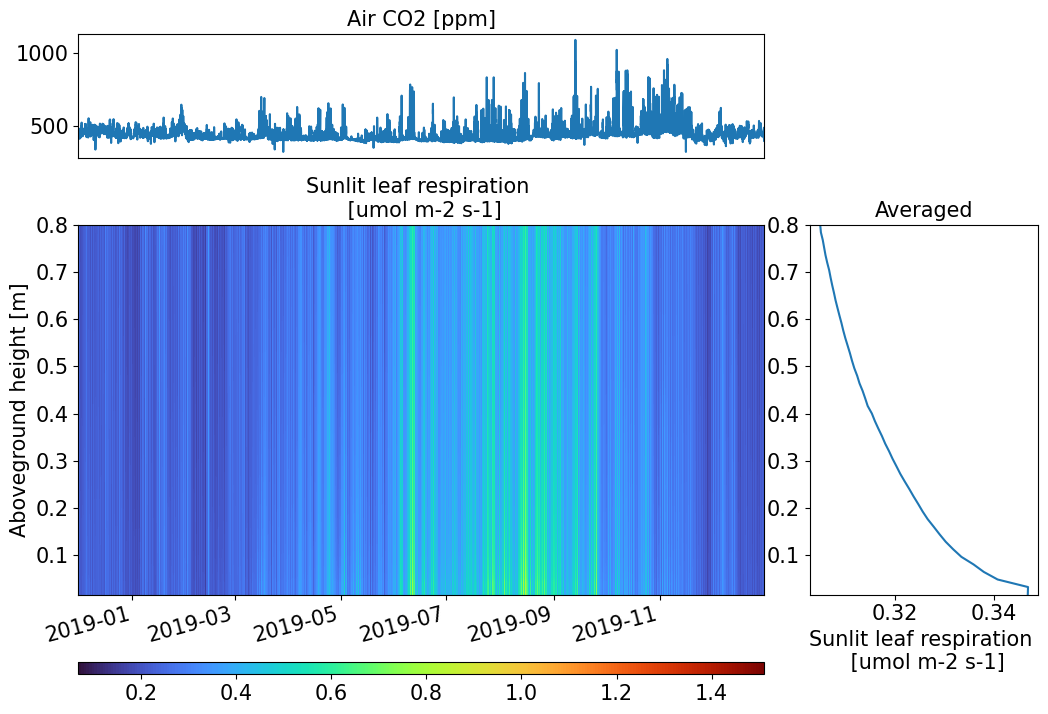

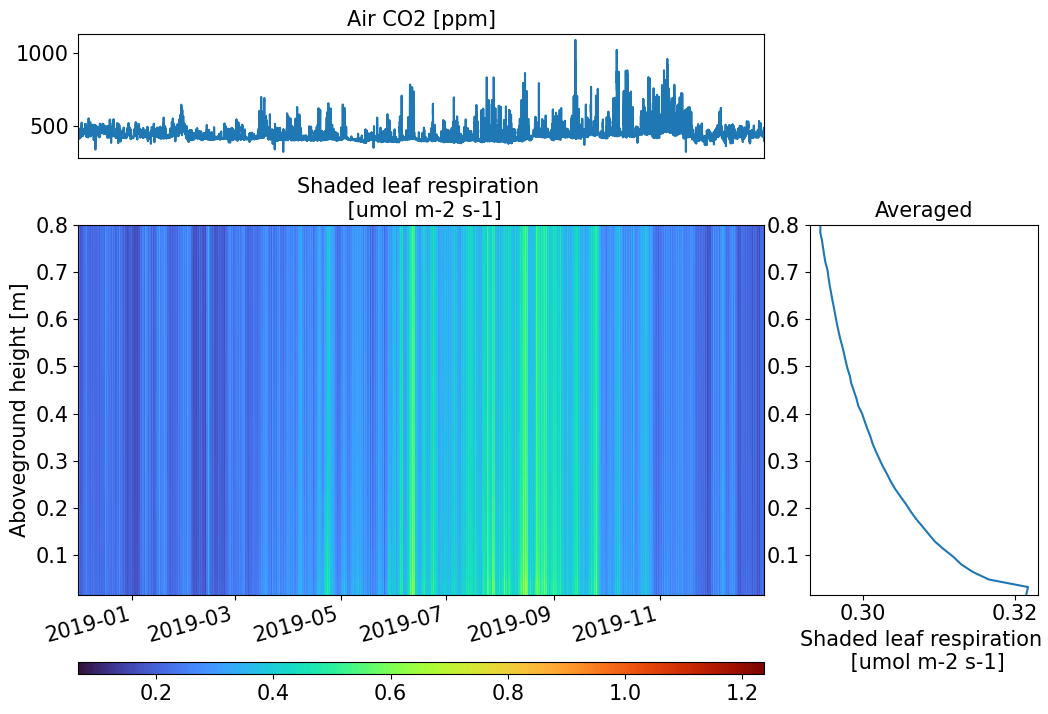

In [18]:
# respiration/photosynthesis
plot_imshow2(
    sun.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Ps.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf photosynthesis \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    sun.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Sunlit leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)
plot_imshow2(
    shade.Resp.T,
    met,
    para.zht1,
    key="co2",
    title="Shaded leaf respiration \n [umol m-2 s-1]",
    cmap="turbo",
)

In [19]:
# met2 = jax.tree_util.tree_map(lambda x: x.reshape(1,816), met)
# jax.vmap(canoak, in_axes=[None,None,0,None,None,None])(para, setup, met2,
#    dij, setup.soil_mtime, setup.niter)

# Local sensitivity analysis

In [21]:
para.RsoilDL

MLP(
  layers=(
    Linear(
      weight=f64[6,2],
      bias=f64[6],
      in_features=2,
      out_features=6,
      use_bias=True
    ),
    Linear(
      weight=f64[6,6],
      bias=f64[6],
      in_features=6,
      out_features=6,
      use_bias=True
    ),
    Linear(
      weight=f64[1,6],
      bias=f64[1],
      in_features=6,
      out_features=1,
      use_bias=True
    )
  )
)

In [22]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canoak_le(para, met, canoak_eqx):
    canoak_eqx = eqx.tree_at(lambda t: t.para, canoak_eqx, para)
    (
        _,
        prof,
        quantum,
        nir,
        ir,
        rnet,
        qin,
        sun_ang,
        leaf_ang,
        lai,
        sun,
        shade,
        soil,
        veg,
        can,
    ) = canoak_eqx(met)
    return can.LE.sum()


@eqx.filter_jit
def compute_grad(para, met):
    grad = df_canoak_le(para, met, canoak_eqx)
    return para, grad


@eqx.filter_jit
def df_canoak_le_batched(para, batched_met, canoak_eqx):
    def compute_grad(para, met):
        grad = df_canoak_le(para, met, canoak_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients


# eqx.filter_make_jaxpr(df_canoak_le3)(para, met, canoak_eqx)

## Perform SA at one time step

In [23]:
start, ntime = 20, 1
met2 = jtu.tree_map(lambda x: x[start : start + ntime], met)

In [24]:
gradients = df_canoak_le(para, met2, canoak_eqx)

In [25]:
gradients.lleaf

Array(-19.88249553, dtype=float64, weak_type=True)

## Perform SA at multiple steps

In [26]:
jax.clear_caches()
gradients = df_canoak_le_batched(para, batched_met, canoak_eqx)

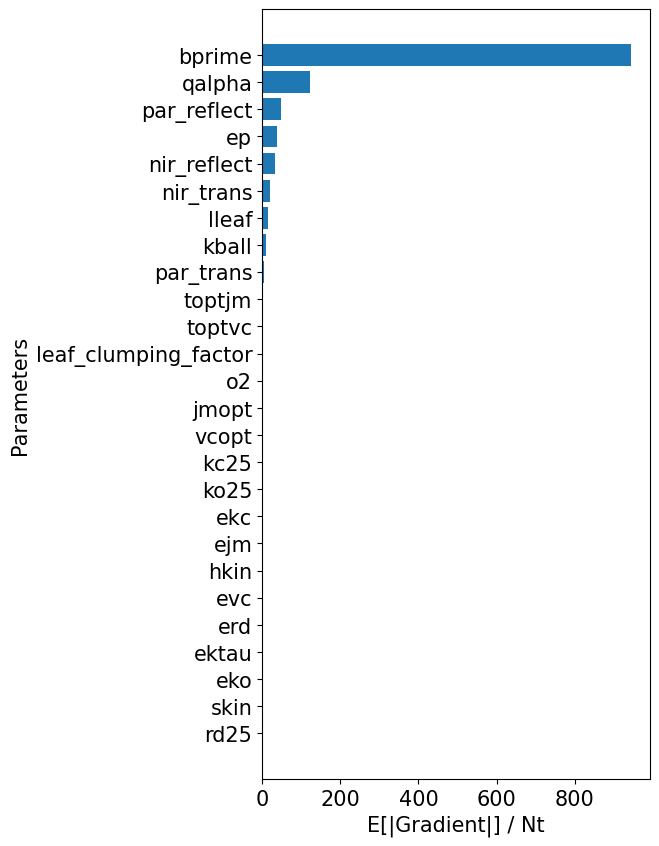

In [27]:
plot_para_sensitivity_ranking(gradients, category="photosyn")
# plot_para_sensitivity_ranking(gradients, category=None)

In [40]:
# gm = jtu.tree_map(lambda x:x.mean(), gradients)
# a, b = jtu.tree_flatten(gm)

In [75]:
# bb = b.node_data()[1]
# names = bb.dynamic_field_names

# Comparison with the observations

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

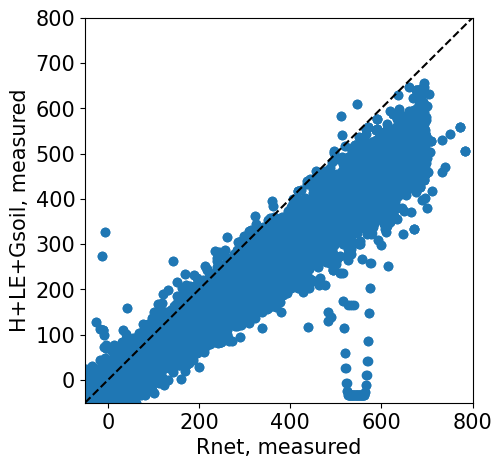

In [28]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 1719.281)'}, xlabel='Measured', ylabel='Simulated'>

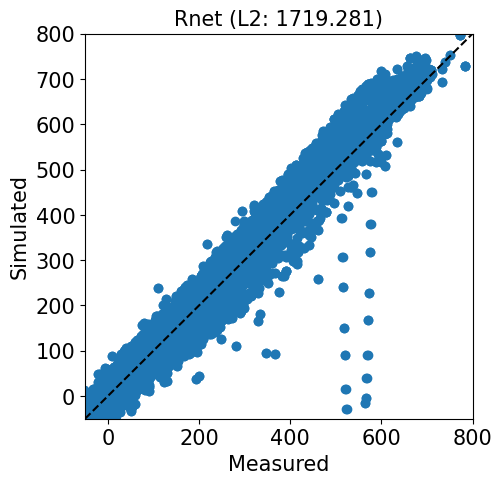

In [29]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

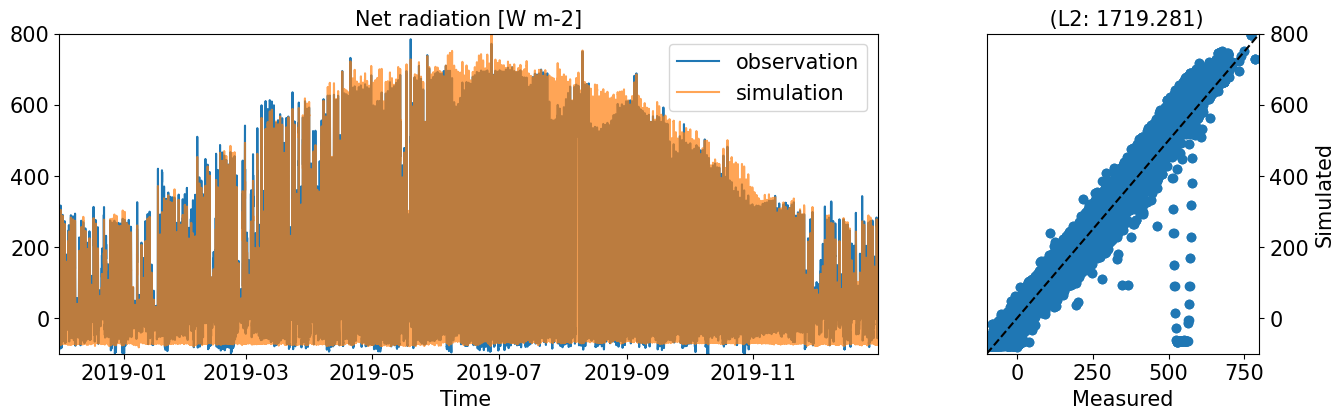

In [30]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    met=met,
    varn="Net radiation [W m-2]",
);

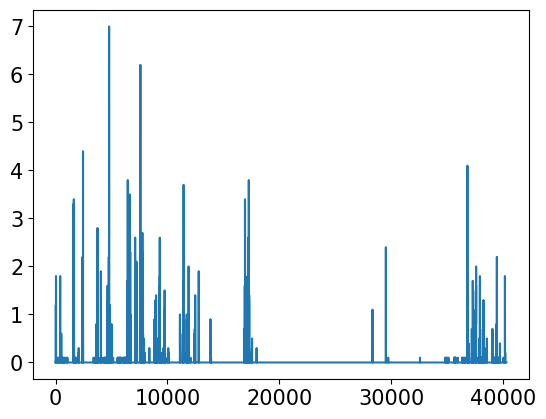

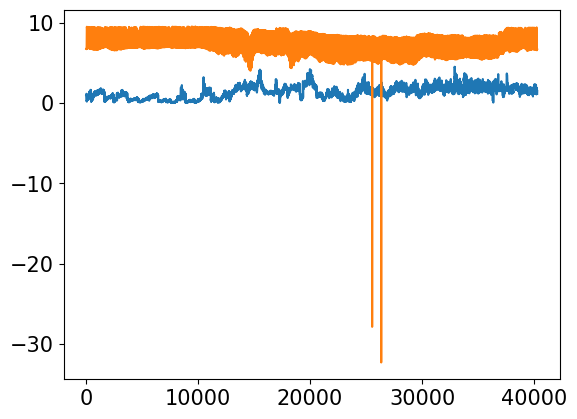

In [31]:
plt.figure(0)
plt.plot(obs.P)
plt.figure(1)
plt.plot(obs.Rsoil)
plt.figure(1)
plt.plot(soil.resp)

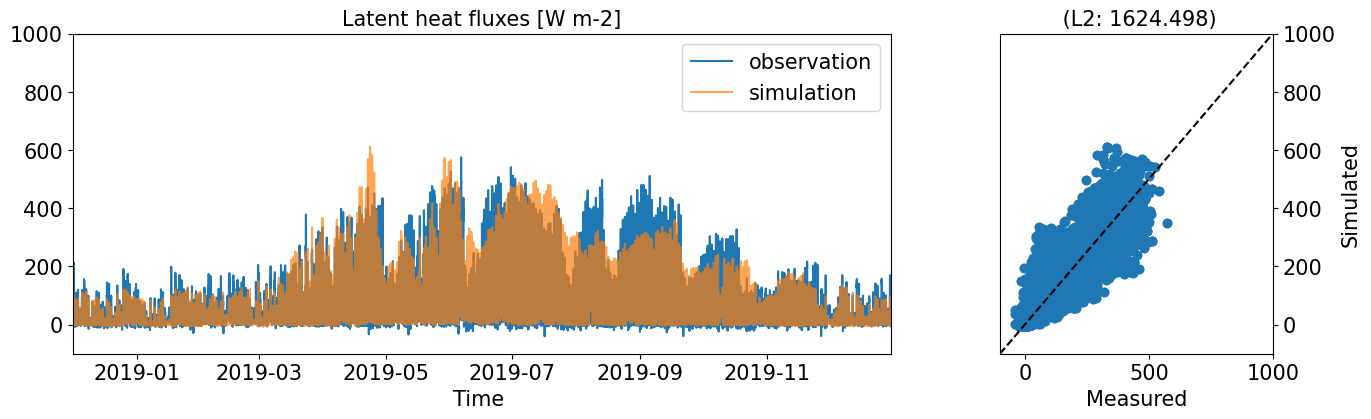

In [32]:
plot_timeseries_obs_1to1(
    obs.LE,
    can.LE,
    lim=[-100, 1000],
    met=met,
    varn="Latent heat fluxes [W m-2]",
);

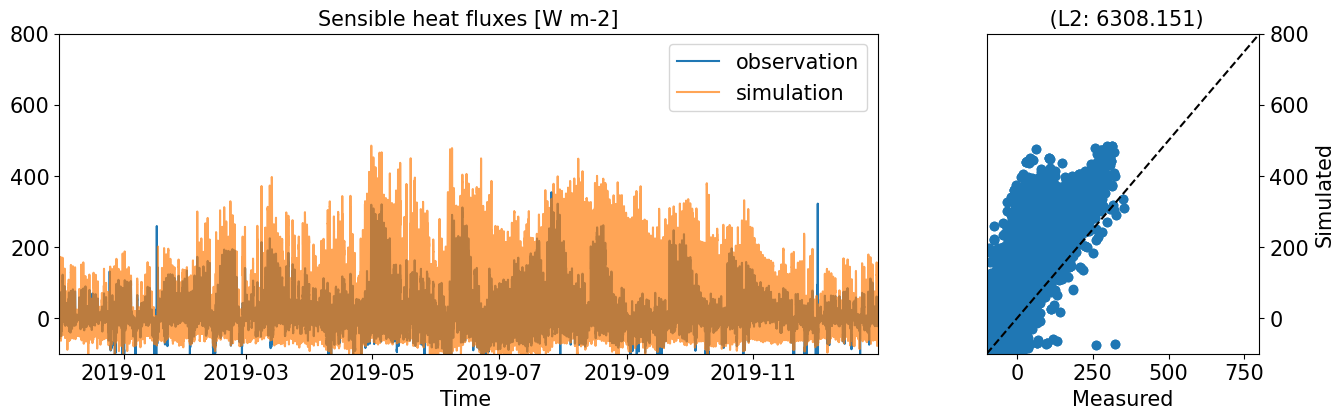

In [33]:
plot_timeseries_obs_1to1(
    obs.H,
    can.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
);

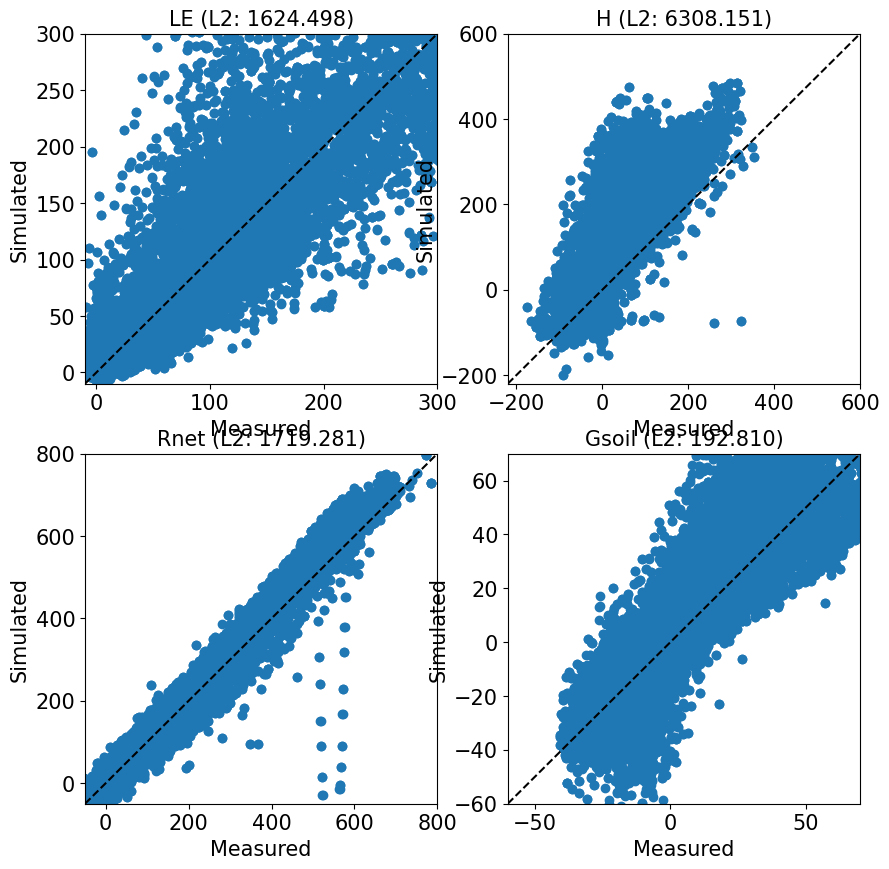

In [34]:
plot_obs_comparison(obs, can);